# Algorithmic Trading Basics

<img align="left" width="80" height="200" src="https://img.shields.io/badge/python-v3.6-blue.svg">
<br>

## Notebook by [Marco Tavora](https://marcotavora.me/)

### Table of contents

1. [Summary](#Summary)
1. [Definitions](#Definitions)
3. [Modules](#Modules)
4. [Time Series](#Time-Series)
5. [Strategy](#Strategy)
6. [Moving Windows](#Moving-Windows)

## Summary 
[[go back to the top]](#Table-of-contents)

I will briefly describe:
- How to build a [trend trading](https://en.wikipedia.org/wiki/Trend_following) strategy
- How to backtest it 
- How we can optimize it 

### Definitions 
[[go back to the top]](#Table-of-contents)


Trend trading can be [defined as](https://en.wikipedia.org/wiki/Trend_following):

> ... a trading strategy according to which one should buy an asset when its price trend goes up, and sell when its trend goes down, expecting price movements to continue.

Again borrowing from [Wikipedia](#https://en.wikipedia.org/wiki/Backtesting), backtesting:
> ... seeks to estimate the performance of a strategy or model if it had been employed during a past period. This requires simulating past conditions with sufficient detail, making one limitation of backtesting the need for detailed historical data. 

### Modules 
[[go back to the top]](#Table-of-contents)

In [1]:
%run modules_algo_trading_v10.ipynb

## Data from `yahoo` or `Quandl`
[[go back to the top]](#Table-of-contents)

In [2]:
start, end = datetime.datetime(2006, 10, 1), datetime.datetime(2012, 1, 1)
apple = pdr.get_data_yahoo('AAPL', start=start, end=end)
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,10.728572,10.838572,10.614285,10.694285,9.477872,178159800
2006-10-03,10.635715,10.707143,10.455714,10.582857,9.379119,197677200
2006-10-04,10.585714,10.780000,10.451428,10.768572,9.543709,207270700
2006-10-05,10.647142,10.880000,10.590000,10.690000,9.474073,170970800
2006-10-06,10.631429,10.720000,10.544286,10.602858,9.396842,116739700


#### Checking for null values

In [3]:
apple.isnull().any().unique()

array([False])

In [4]:
start, end ="2006-10-01", "2011-01-01"
apple = quandl.get("WIKI/AAPL", start_date=start, end_date=end)
apple.columns = [el.lower().replace('.', '').replace(' ', '_') for el in apple.columns]
apple.head()

,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
Date,,,,,,,,,,,,
2006-10-02,75.10,75.870,74.30,74.86,25451400.0,0.0,1.0,9.651397,9.750352,9.548586,9.620553,178159800.0
2006-10-03,74.45,74.950,73.19,74.07,28239600.0,0.0,1.0,9.567863,9.632120,9.405935,9.519027,197677200.0
2006-10-04,74.10,75.462,73.16,75.38,29610100.0,0.0,1.0,9.522883,9.697919,9.402080,9.687381,207270700.0
2006-10-05,74.53,76.160,74.13,74.83,24424400.0,0.0,1.0,9.578144,9.787621,9.526738,9.616698,170970800.0
2006-10-06,74.42,75.040,73.81,74.22,16677100.0,0.0,1.0,9.564007,9.643686,9.485614,9.538304,116739700.0


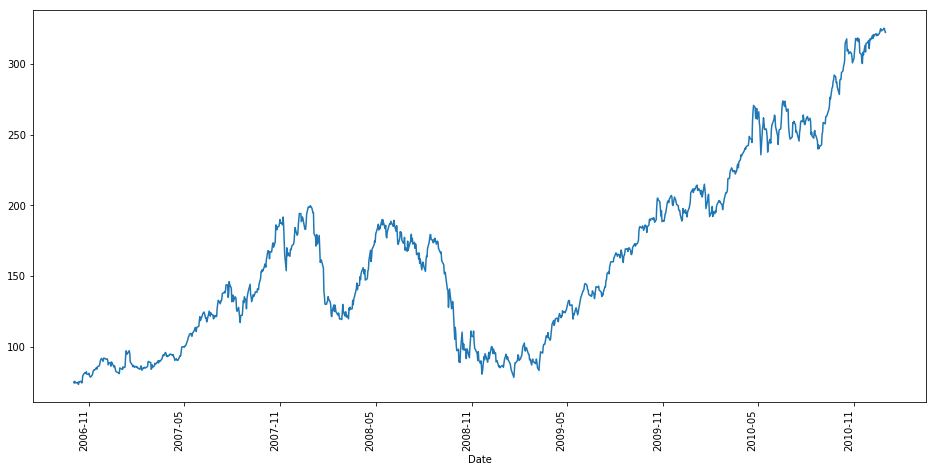

In [5]:
plt.rcParams['figure.figsize'] = 16, 8
apple['close'].plot(grid=False, rot=90);
plt.show();

## Moving Average Crossover Strategy
[[go back to the top]](#Table-of-contents)


In general, a trading strategy involves going into long and/or short positions following some plan. One example, maybe the simplest, is the **moving average crossover** strategy. Following this strategy, one decides to buy or sell when the time series of two moving averages, with different lookback periods, cross. More concretely:
- When the short moving average (SMA) becomes greater than the long moving average (LMA), one enter (i.e. buys, or goes long)
- When the long moving average (LMA) becomes greater than the short moving average (SMA), one exits

Roughly speaking, the *rationale* behind this strategy is the following. Short-term trends are captured using SMA. When the SMA crosses above the LMA, one identifies a short-term upward trend and the stock is purchased. When the LMA crosses above the SMA one does the opposite.

An example of the use of moving averages follows. Consider the first five rows and a window of size 3:

In [10]:
ten_rows = apple[['close']].head()
ten_rows

,close
Date,
2006-10-02,74.86
2006-10-03,74.07
2006-10-04,75.38
2006-10-05,74.83
2006-10-06,74.22


In [7]:
ten_rows['close'].rolling(window=3, min_periods=1,center=False).mean()

Date
2006-10-02    74.860
2006-10-03    74.465
2006-10-04    74.770
2006-10-05    74.760
2006-10-06    74.810
Name: close, dtype: float64

The third entry is:

In [12]:
window_size = 3
(ten_rows.iloc[0,:] + ten_rows.iloc[1, :] + ten_rows.iloc[2, :])/window_size

close    74.77
dtype: float64

Note that the rows with index smaller than the window are unaltered since the moving average needs are least 3 elements (the window size) to be calculated.

In [14]:
import fix_yahoo_finance as yf
yf.pdr_override() 

The code implementation of this strategy consists in the following steps:
- First set the sizes of the short moving window `smw` and long moving window `lmw`
- Create an empty `DataFrame` for signals (called `sig` here) and fill the columns of `sig` with the SMA and LMA values from the `close` price column

The close price column is:

In [15]:
apple[['close']].head()

,close
Date,
2006-10-02,74.86
2006-10-03,74.07
2006-10-04,75.38
2006-10-05,74.83
2006-10-06,74.22


The two steps above are:

In [16]:
smw, lmw = 40, 100
signal_df = pd.DataFrame(index=apple.index, 
                         columns = ['sma','lma' ])

signal_df['signal'], signal_df['sma'], signal_df['lma'] = 0.0, 0.0, 0.0

signal_df['sma'] = apple['close'].rolling(window=smw,
                                             min_periods=1, 
                                             center=False).mean()

signal_df['lma'] = apple['close'].rolling(window=lmw, 
                                            min_periods=1, 
                                            center=False).mean()

- Fill the `signal` column inserting 1s when the value of column `sma` is larger than `lma` only for the period greater than `smw`.

For that we use the `np.where` function. A simple example of the latter is:

In [17]:
lst = np.arange(5,10)
print('lst is:', lst)
print('Insert 1s in the positions of the elements in lst that are smaller than 7 and insert 0s otherwise:')
print(np.where(lst < 7, 1, 0))

lst is: [5 6 7 8 9]
Insert 1s in the positions of the elements in lst that are smaller than 7 and insert 0s otherwise:
[1 1 0 0 0]


In [18]:
signal_df['signal'][smw:] = np.where(signal_df['sma'][smw:] > signal_df['lma'][smw:], 1.0, 0.0) 
signal_df.iloc[smw:, :].head(6)

,sma,lma,signal
Date,,,
2006-11-28,80.76700,80.622927,1.0
2006-11-29,81.21025,80.889048,1.0
2006-11-30,81.61725,81.139535,1.0
2006-12-01,82.02950,81.370909,1.0
2006-12-04,82.45200,81.587556,1.0
2006-12-05,82.86800,81.798043,1.0


- Create a column of positions `pos`. Rows correspondig to long positions will have 1s. Notice below e.g. that on 2000-02-07, `sma`>`lma` and one changes the position (buys the stock). In the following day, one still has `sma`>`lma` so the position is kept and the entry in the position column will be 0. The meaning of the `.diff` method is illustrated below. Since:

        signal_df.iloc[smw:, :]['sma'][4] = 103.934
        signal_df.iloc[smw:, :]['sma'][3] = 103.206
        
        -> signal_df.iloc[smw:, :]['sma'][4]-signal_df.iloc[smw:, :]['sma'][3] = 0.728

In [19]:
round(signal_df.iloc[smw:, :]['sma'].diff()[4], 3)
round(signal_df.iloc[smw:, :]['sma'][4] - signal_df.iloc[smw:, :]['sma'][3], 3)

0.422

0.422

In [20]:
signal_df['pos'] = signal_df['signal'].diff()
signal_df.iloc[smw:, :].head(20)

,sma,lma,signal,pos
Date,,,,
2006-11-28,80.76700,80.622927,1.0,1.0
2006-11-29,81.21025,80.889048,1.0,0.0
2006-11-30,81.61725,81.139535,1.0,0.0
2006-12-01,82.02950,81.370909,1.0,0.0
2006-12-04,82.45200,81.587556,1.0,0.0
2006-12-05,82.86800,81.798043,1.0,0.0
2006-12-06,83.26850,81.968936,1.0,0.0
2006-12-07,83.61375,82.074583,1.0,0.0
2006-12-08,83.93875,82.200816,1.0,0.0


In [21]:
apple.head()

,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
Date,,,,,,,,,,,,
2006-10-02,75.10,75.870,74.30,74.86,25451400.0,0.0,1.0,9.651397,9.750352,9.548586,9.620553,178159800.0
2006-10-03,74.45,74.950,73.19,74.07,28239600.0,0.0,1.0,9.567863,9.632120,9.405935,9.519027,197677200.0
2006-10-04,74.10,75.462,73.16,75.38,29610100.0,0.0,1.0,9.522883,9.697919,9.402080,9.687381,207270700.0
2006-10-05,74.53,76.160,74.13,74.83,24424400.0,0.0,1.0,9.578144,9.787621,9.526738,9.616698,170970800.0
2006-10-06,74.42,75.040,73.81,74.22,16677100.0,0.0,1.0,9.564007,9.643686,9.485614,9.538304,116739700.0


In [22]:
apple.shape

(1071, 12)

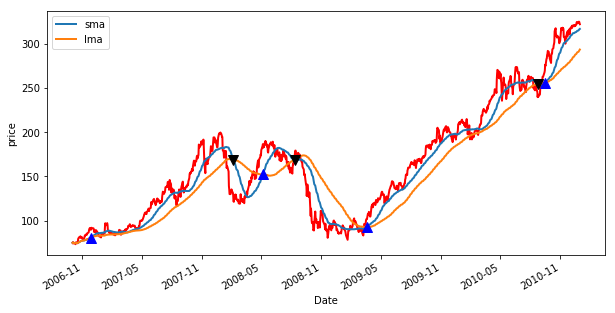

In [23]:
ylabel, col, cols_ma ='price', 'close', ['sma', 'lma']
afa.plot_function_new(apple, signal_df, ylabel, col, cols_ma, 0, apple.shape[0])

A subsection of the plot makes the strategy clearer:

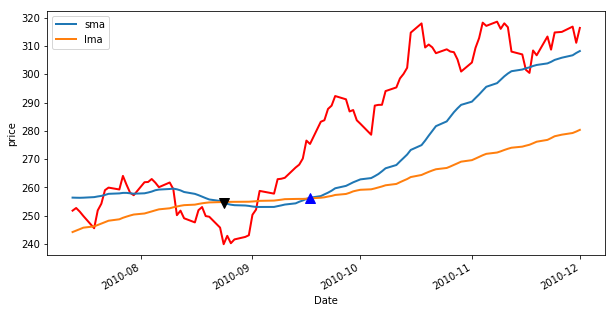

In [24]:
afa.plot_function_new(apple, signal_df, ylabel, col, cols_ma, 950, 1050)

## Backtesting Steps
[[go back to the top]](#Table-of-contents)

Steps:
- We first set the initial capital to, say, 2MM
- Buy a $N$ shares
- Initialize the portfolio with value owned initially and store the difference in shares owned 
- Add a `holdings` column containing the values of the positions bought times the adjusted closed price

`cash`, `total` and `return` to portfolio
- Plot equity curve 
- Plot the "buy" and "sell" trades versus the equity curve

In [25]:
aux = pd.concat([signal_df[['signal']].iloc[smw+3:smw+10, :], apple[['adj_close']].iloc[smw+3:smw+10, :]], axis=1)
aux['holdings'] = 100*aux['signal']*aux['adj_close']
aux

,signal,adj_close,holdings
Date,,,
2006-12-01,1.0,11.735893,1173.589279
2006-12-04,1.0,11.710190,1171.019000
2006-12-05,1.0,11.729467,1172.946709
2006-12-06,1.0,11.544407,1154.440702
2006-12-07,1.0,11.185853,1118.585313
2006-12-08,1.0,11.342640,1134.264014
2006-12-11,1.0,11.405612,1140.561197


In [26]:
initial_capital, N = 1000000.0, 100
pos = pd.DataFrame(index=signal_df.index).fillna(0.0)
pos['AAPL'] = 100*signal_df['signal']   
ptf = pos.multiply(apple['adj_close'], axis=0)
ptf.iloc[smw+3:smw+10, :]

,AAPL
Date,
2006-12-01,1173.589279
2006-12-04,1171.019000
2006-12-05,1172.946709
2006-12-06,1154.440702
2006-12-07,1118.585313
2006-12-08,1134.264014
2006-12-11,1140.561197


In [27]:
pos_diff = pos.diff()
ptf['holdings'] = (pos.multiply(apple['adj_close'], axis=0)).sum(axis=1)
ptf['cash'] = initial_capital - (pos_diff.multiply(apple['adj_close'], axis=0)).sum(axis=1).cumsum()   
ptf['tot'] = (ptf['cash'] + ptf['holdings'])/1000000
ptf['return'] = (ptf['tot'].pct_change())

In [28]:
ptf

,AAPL,holdings,cash,tot,return
Date,,,,,
2006-10-02,0.000000,0.000000,1000000.00000,1.000000,NaN
2006-10-03,0.000000,0.000000,1000000.00000,1.000000,0.000000e+00
2006-10-04,0.000000,0.000000,1000000.00000,1.000000,0.000000e+00
2006-10-05,0.000000,0.000000,1000000.00000,1.000000,0.000000e+00
2006-10-06,0.000000,0.000000,1000000.00000,1.000000,0.000000e+00
2006-10-09,0.000000,0.000000,1000000.00000,1.000000,0.000000e+00
2006-10-10,0.000000,0.000000,1000000.00000,1.000000,0.000000e+00
2006-10-11,0.000000,0.000000,1000000.00000,1.000000,0.000000e+00
2006-10-12,0.000000,0.000000,1000000.00000,1.000000,0.000000e+00


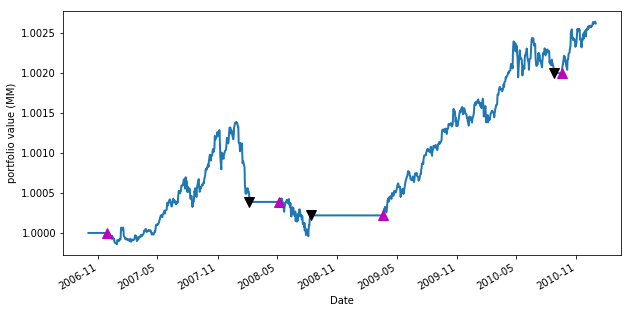

In [34]:
df, ylabel, col = ptf, 'portfolio value (MM)', 'tot'
afa.plot_function_3(df, signal_df, ylabel, col, pos, 0, -1)

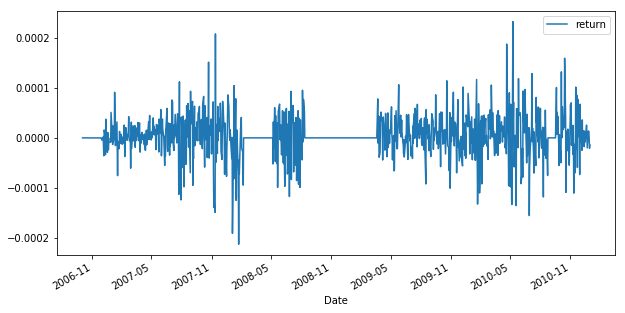

In [37]:
ptf[['return']].plot();

### Sharpe Ratio and Maximum Drawdown
[[go back to the top]](#Table-of-contents)

The Sharpe ration reads:

$${S_a} = \frac{{E[{R_a} - {R_b}]}}{{{\sigma _a}}} = \frac{{E[{R_a} - {R_b}]}}{{\sqrt {{\rm{var}}[{R_a} - {R_b}]} }},$$

where $R_{a}$ is the asset return and $R_b$ is the risk free rate. From Wikipedia:

> The Sharpe ratio characterizes how well the return of an asset compensates the investor for the risk taken. When comparing two assets versus a common benchmark, the one with a higher Sharpe ratio provides better return for the same risk (or, equivalently, the same return for lower risk).

Using $R_b=0$ for simplicity:

In [38]:
returns = ptf['return']
sharpe_ratio = np.sqrt(252)*(returns.mean() / returns.std())
print('sharpe_ratio is:',round(sharpe_ratio, 3))

sharpe_ratio is: 0.945


The maximum drawdown measures the largest drop in portfolio value of a portfolio.

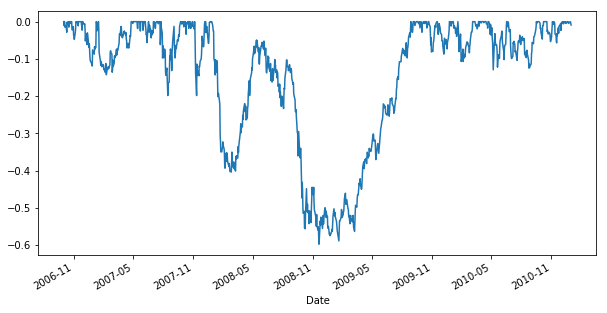

In [52]:
import auxiliar as af

window = 252
rolling_max = apple['adj_close'].rolling(window, min_periods=1).max()
daily_drawdown = (apple['adj_close']/rolling_max - 1.0)
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()
daily_drawdown.plot()

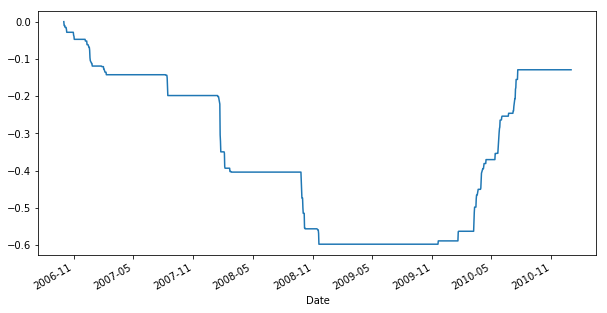

In [53]:
max_daily_drawdown.plot()
plt.show();

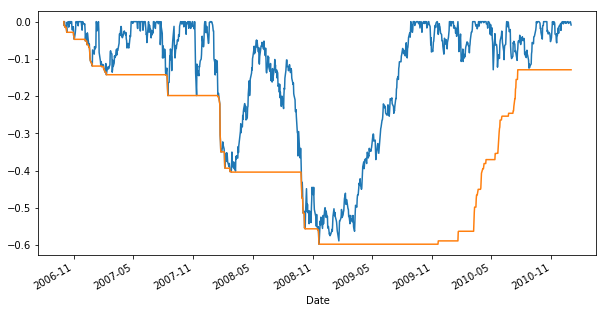

In [54]:
daily_drawdown.plot()
max_daily_drawdown.plot()
plt.show();

In [51]:
af.s_to_df(max_daily_drawdown, 'daily_drawdown').sort_values(by = 'daily_drawdown', ascending=True)

,index,daily_drawdown
662,2009-05-20,-0.597208
647,2009-04-29,-0.597208
648,2009-04-30,-0.597208
649,2009-05-01,-0.597208
650,2009-05-04,-0.597208
651,2009-05-05,-0.597208
652,2009-05-06,-0.597208
653,2009-05-07,-0.597208
654,2009-05-08,-0.597208
655,2009-05-11,-0.597208
